In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import glob
import rasterio
import rioxarray
import xarray as xr
from PIL import Image
import warnings
import datetime
warnings.filterwarnings('ignore')


In [2]:
from collections import Counter
def check_size_most(img_path):
    ''' Finding the most occuring size of the image in the dataset'''
    # img_path = glob.glob(img_path)
    img_size = []
    for i in img_path:
        img = rioxarray.open_rasterio(i)
        img_size.append(img.shape)
    return Counter(img_size).most_common(1).pop()[0]
    
def clean_data_by_size(img_path):
    img_path = glob.glob(img_path, recursive=True)
    print("Initial size of dataset", len(img_path))
    size= check_size_most(img_path)
    print("Most common size of the dataset", size)
    #delete the images from img_path list which are not of the most common size
    for i in img_path:
        img = rioxarray.open_rasterio(i)
        if img.shape != size:
            img_path.remove(i)
    print("Final size of dataset(after removing faulty size images)", len(img_path))
    return img_path

def clean_data_by_black_pixels(img_path_list):
    black_pixels = []
    for i in img_path_list:
        img = rioxarray.open_rasterio(i)
        black_pixels.append(np.count_nonzero(img.data[0:3].transpose(1, 2, 0) == 0))
    img_path_median = []
    for i in range(len(img_path_list)):
        if black_pixels[i] <= np.median(black_pixels):
            img_path_median.append(img_path_list[i])
    print("Final size of dataset(after removing faulty black pixels in images)", len(img_path_median))
    return img_path_median

def clean_data_by_white_pixels(img_path_list, threshold=200):
    white_pixels = []
    for i in img_path_list:
        img = rioxarray.open_rasterio(i)
        white_pixels.append(np.count_nonzero(img.data[0:3].transpose(1, 2, 0)  >= threshold))

    img_path_mean_white = []
    for i in range(len(img_path_list)):
        if white_pixels[i] <= np.mean(white_pixels):
            img_path_mean_white.append(img_path_list[i])
    print("Final size of dataset(after removing faulty white pixels in images)", len(img_path_mean_white))
    return img_path_mean_white


def find_day(date_string):
    try:
        date = datetime.datetime.strptime(date_string, "%Y-%m-%d")
        day = date.strftime("%A")
        return day
    except ValueError:
        return "Invalid date format. Please provide the date in YYYY-MM-DD format."
    


def label_csv(clean_img_path):
    df = pd.DataFrame(columns=['image_path', 'day'])
    for i in clean_img_path:
        date_in = i.split('/')[-1].split('_')[0]
        year = date_in[0:4]
        month = date_in[4:6]
        day = date_in[6:8]
        date_string = f"{year}-{month}-{day}"
        df = df.append({'image_path': i, 'day': find_day(date_string)}, ignore_index=True)
    df['label'] = df['day'].apply(lambda x: 1 if x in ['Sunday'] else 0)
    print("Class distribution in dataset:", df.label.value_counts())
    return df

In [3]:
img_path = "/home/akansh-i2sc/Desktop/Research/LR-car_detect_research/data/PSScene/**/*.tif"
clean_1 = clean_data_by_size(img_path)
clean_2 = clean_data_by_black_pixels(clean_1)
clean_3 = clean_data_by_white_pixels(clean_2)

Initial size of dataset 242
Most common size of the dataset (4, 73, 49)
Final size of dataset(after removing faulty size images) 242
Final size of dataset(after removing faulty black pixels in images) 229
Final size of dataset(after removing faulty white pixels in images) 209


In [6]:
#giving labels to the images
df = label_csv(clean_3)

Class distribution in dataset: 0    181
1     28
Name: label, dtype: int64


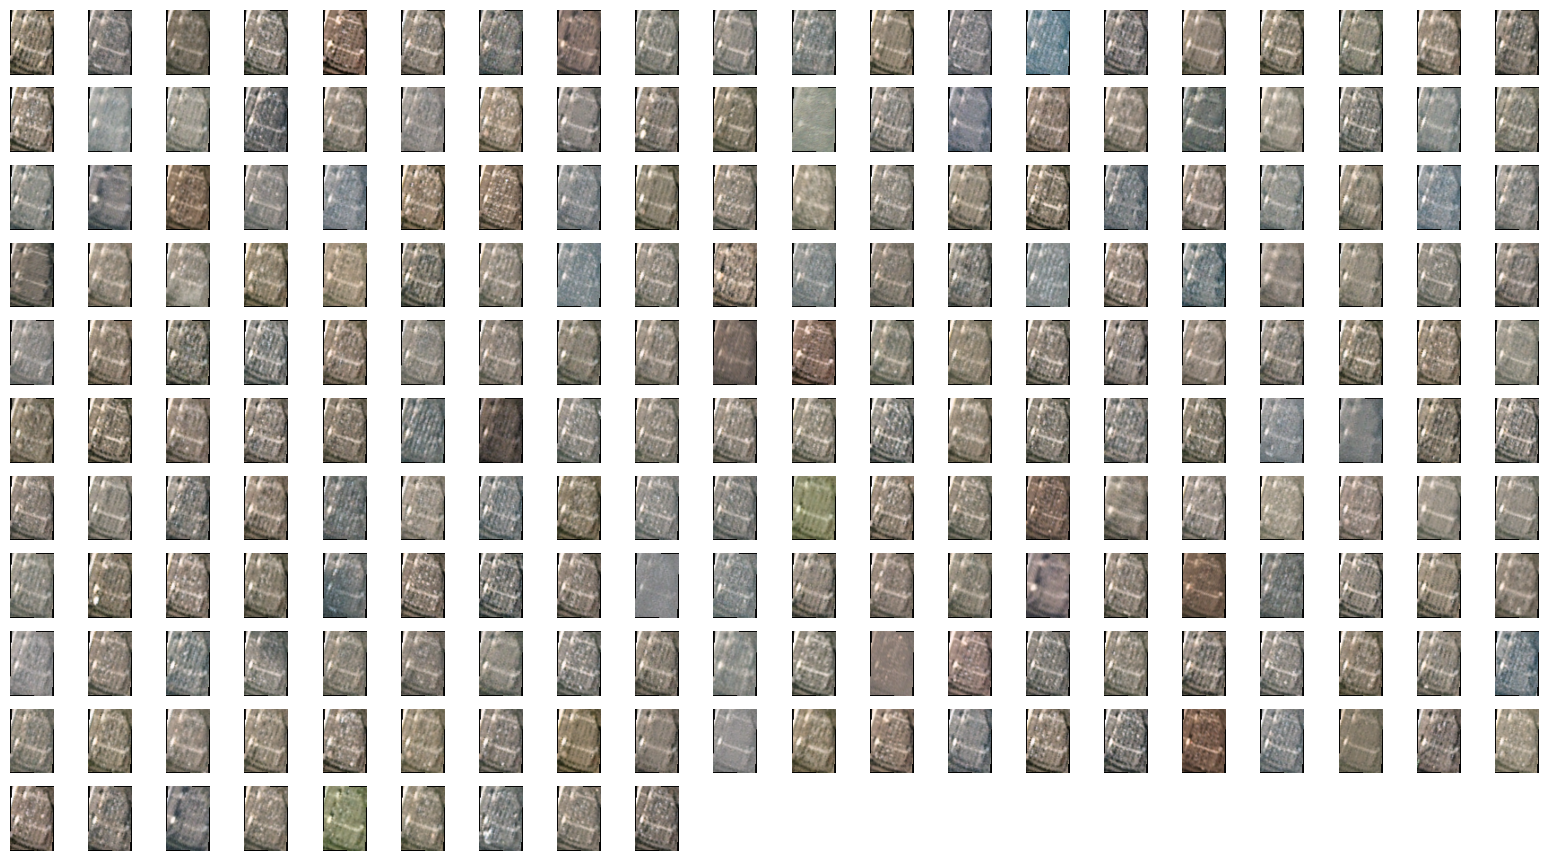

In [12]:
#All images
plt.figure(figsize=(20,20))
for i in range(len(clean_3)):
    plt.subplot(20,20,i+1)
    img = rioxarray.open_rasterio(clean_3[i])
    plt.imshow(img.data[0:3].transpose(1, 2, 0))
    plt.axis('off')

### Sunday Images

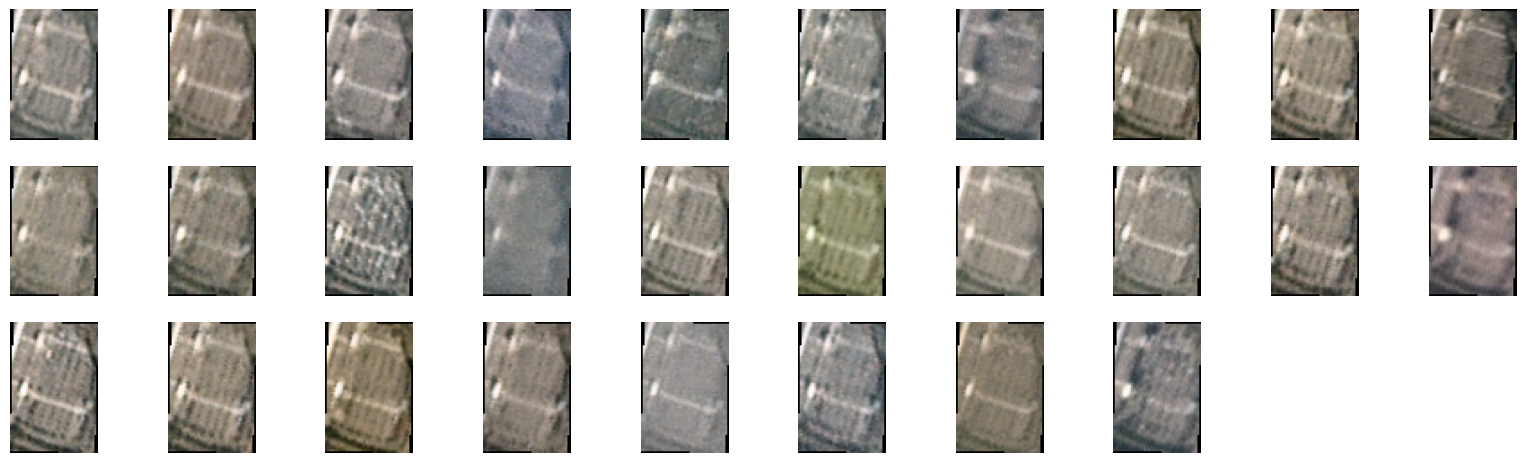

In [11]:
#All sunday images
plt.figure(figsize=(20,20))
for i in range(len(df[df.label == 1])):
    plt.subplot(10,10,i+1)
    img = rioxarray.open_rasterio(df[df.label == 1].image_path.values[i])
    plt.imshow(img.data[0:3].transpose(1, 2, 0))
    plt.axis('off')

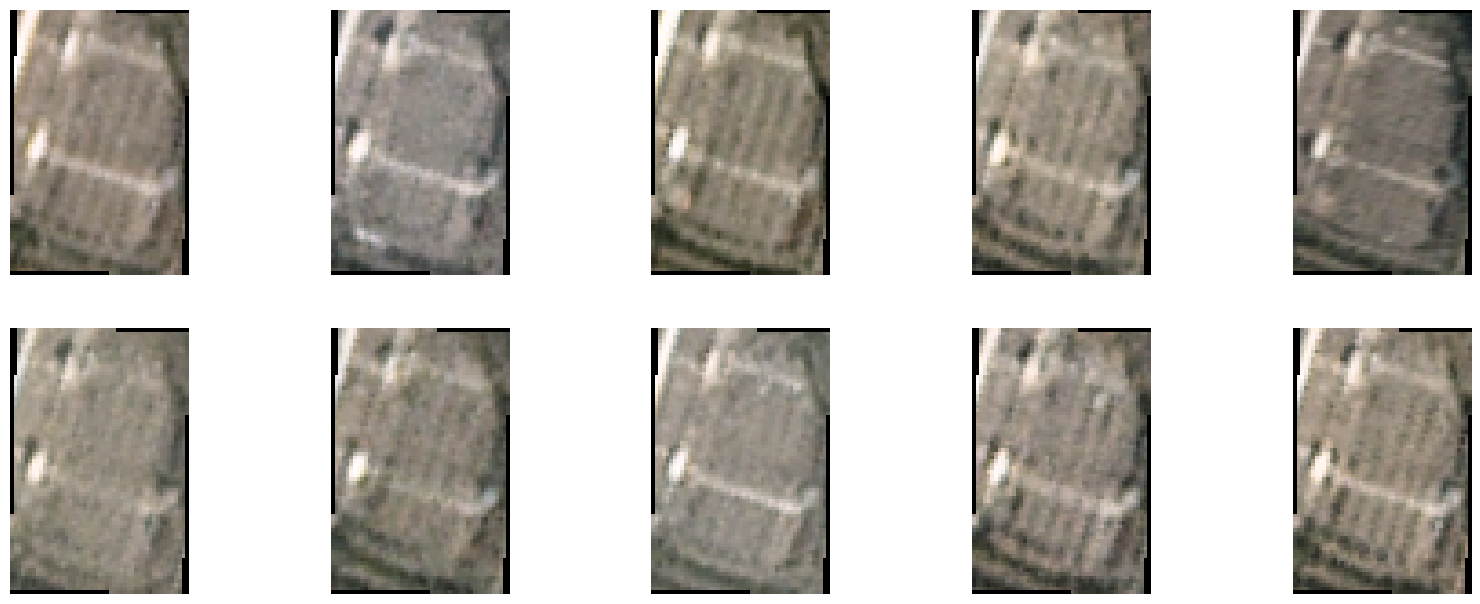

In [19]:
#Manually selecting 10 images of Sunday with uniform condtion. 
l = [1,2,7,8,9,10,11,17,18,21]
plt.figure(figsize=(20,20))
for i in range(len(l)):
    plt.subplot(5,5,i+1)
    img = rioxarray.open_rasterio(df[df.label == 1].image_path.values[l[i]])
    plt.imshow(img.data[0:3].transpose(1, 2, 0))
    plt.axis('off')


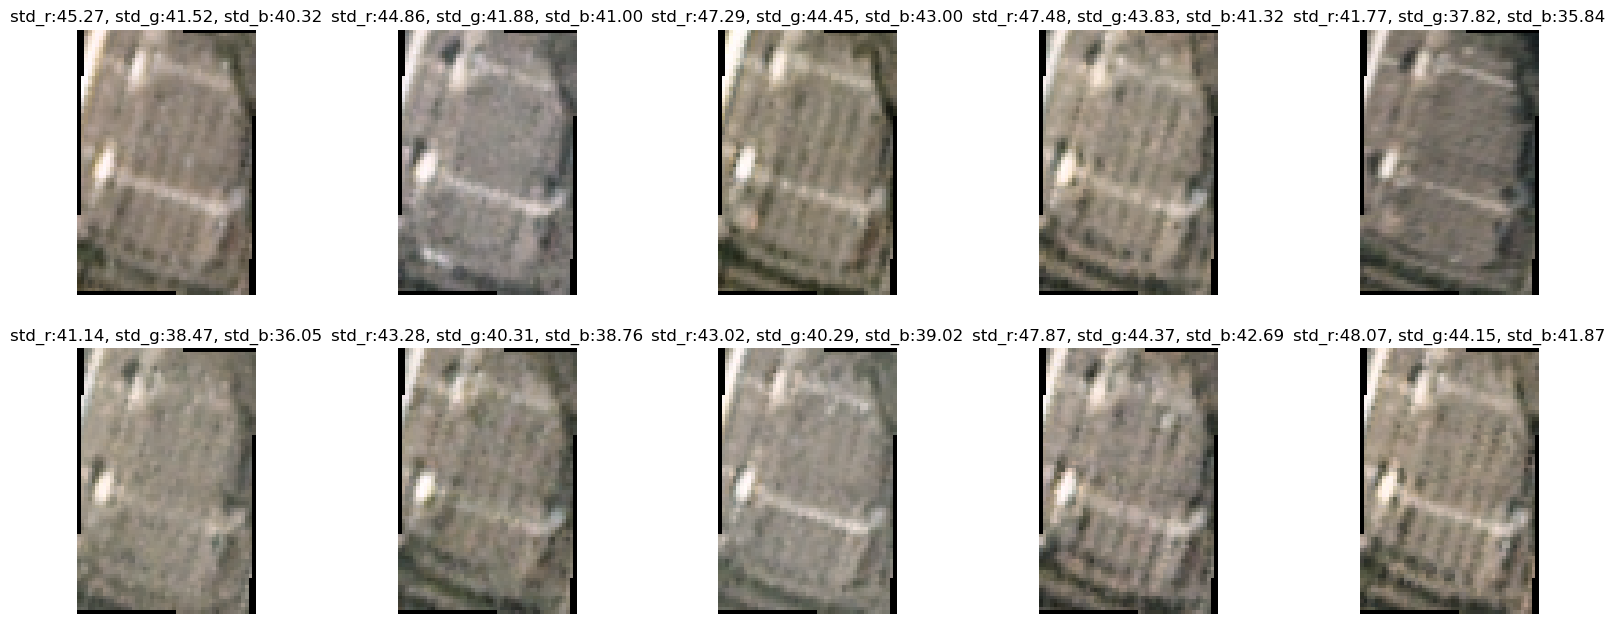

In [23]:
#calculating standard deviation of the each pixel in RGB channel
std_r = []
std_g = []
std_b = []
for i in range(len(l)):
    img = rioxarray.open_rasterio(df[df.label == 1].image_path.values[l[i]])
    img = img.data[0:3].transpose(1, 2, 0)
    std_r.append(np.std(img[:,:,0]))
    std_g.append(np.std(img[:,:,1]))
    std_b.append(np.std(img[:,:,2]))

#ploting image wuth std deviation of three channels as title
plt.figure(figsize=(20,20))
for i in range(len(l)):
    img = rioxarray.open_rasterio(df[df.label == 1].image_path.values[l[i]])
    img = img.data[0:3].transpose(1, 2, 0)
    plt.subplot(5,5,i+1)
    plt.imshow(img)
    plt.title(f"std_r:{std_r[i]:.2f}, std_g:{std_g[i]:.2f}, std_b:{std_b[i]:.2f}")
    plt.axis('off')

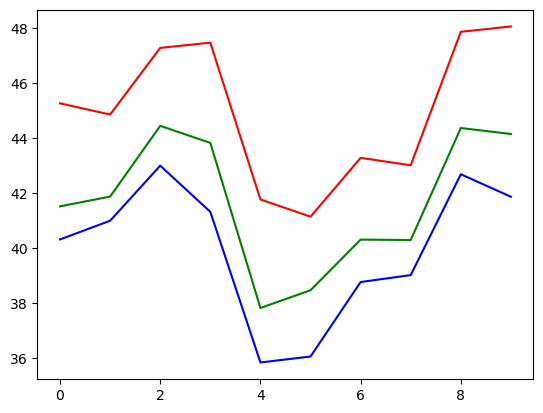

In [26]:
plt.plot(std_r, label='std_r', color='red')
plt.plot(std_g, label='std_g', color='green')
plt.plot(std_b, label='std_b', color='blue')

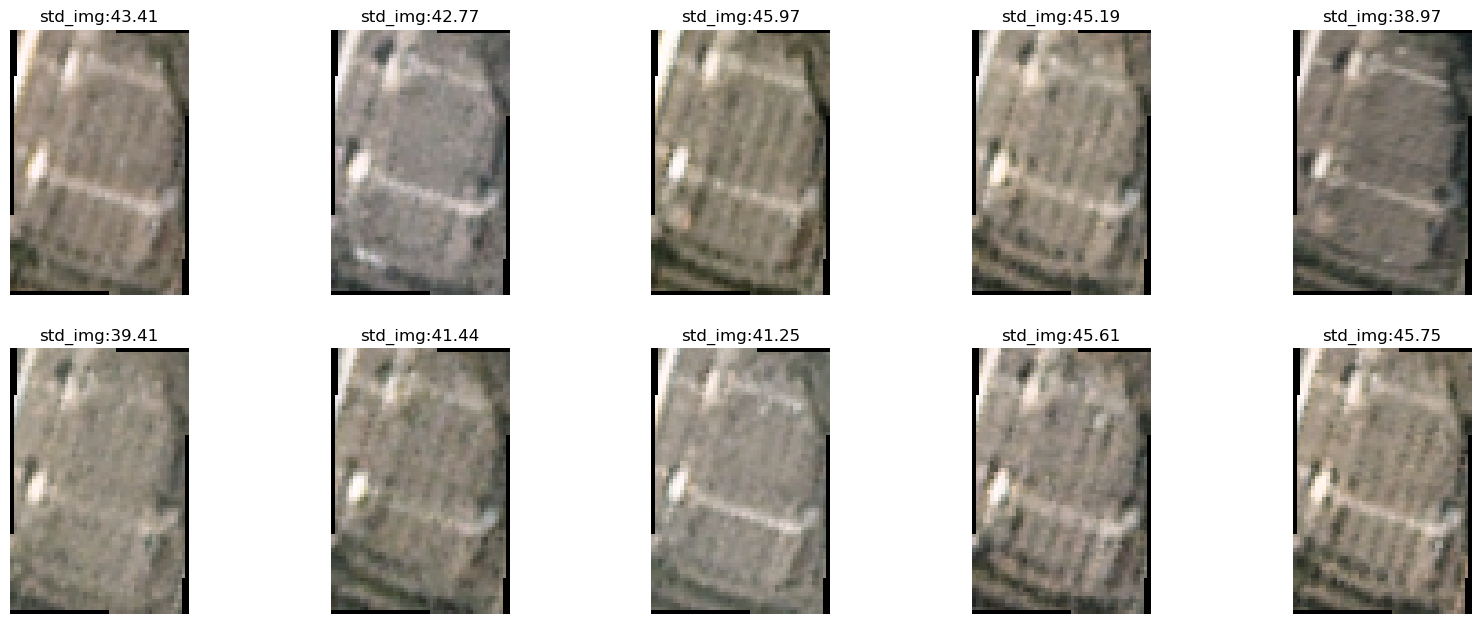

In [27]:
#calculating standard devaition of the of whole image
std_img = []
for i in range(len(l)):
    img = rioxarray.open_rasterio(df[df.label == 1].image_path.values[l[i]])
    img = img.data[0:3].transpose(1, 2, 0)
    std_img.append(np.std(img))

#ploting image with std deviation of three channels as title
plt.figure(figsize=(20,20))
for i in range(len(l)):
    img = rioxarray.open_rasterio(df[df.label == 1].image_path.values[l[i]])
    img = img.data[0:3].transpose(1, 2, 0)
    plt.subplot(5,5,i+1)
    plt.imshow(img)
    plt.title(f"std_img:{std_img[i]:.2f}")

##### Deviation from median image

In [30]:
def create_median_image(images_path):

    first_img = rioxarray.open_rasterio(images_path[0])

    width, height = first_img.data[0:3].transpose(1, 2, 0).shape[0:2]
    num_images = len(images_path)

    red_values = np.zeros(( width,height, num_images), dtype=np.uint8)
    green_values = np.zeros(( width,height, num_images), dtype=np.uint8)
    blue_values = np.zeros(( width,height, num_images), dtype=np.uint8)


    for i,j in enumerate(images_path):
        img = rioxarray.open_rasterio(j).data[0:3].transpose(1, 2, 0)
        try:
            red_values[:, :, i], green_values[:, :, i], blue_values[:, :, i] = img[:, :, 0], img[:, :, 1], img[:, :, 2]
        except:
            pass
    
    red_median = np.median(red_values, axis=2)
    green_median = np.median(green_values, axis=2)
    blue_median = np.median(blue_values, axis=2)
    img_arr = np.uint8(np.dstack((red_median, green_median, blue_median)))
    median_image = Image.fromarray(img_arr)
    
    return img_arr, median_image


Text(0.5, 1.0, 'std_img:42.16')

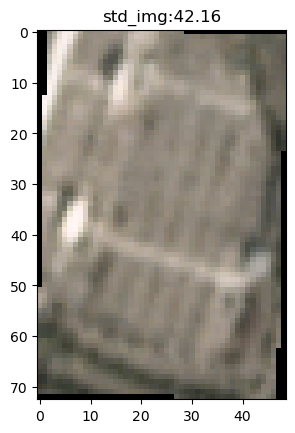

In [35]:
med_img_arr, median_img = create_median_image([df[df.label == 1].image_path.values[l[i]] for i in range(len(l))])
plt.imshow(med_img_arr)
plt.title(f"std_img:{np.std(med_img_arr):.2f}")

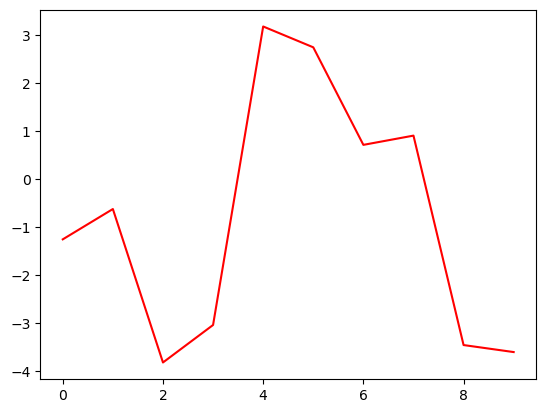

In [36]:
#difference of standard deviation of median image and each image
std_diff = []
for i in range(len(l)):
    img = rioxarray.open_rasterio(df[df.label == 1].image_path.values[l[i]])
    img = img.data[0:3].transpose(1, 2, 0)
    std_diff.append(np.std(med_img_arr) - np.std(img))

plt.plot(std_diff, label='std_diff', color='red')

#### Saturday Images

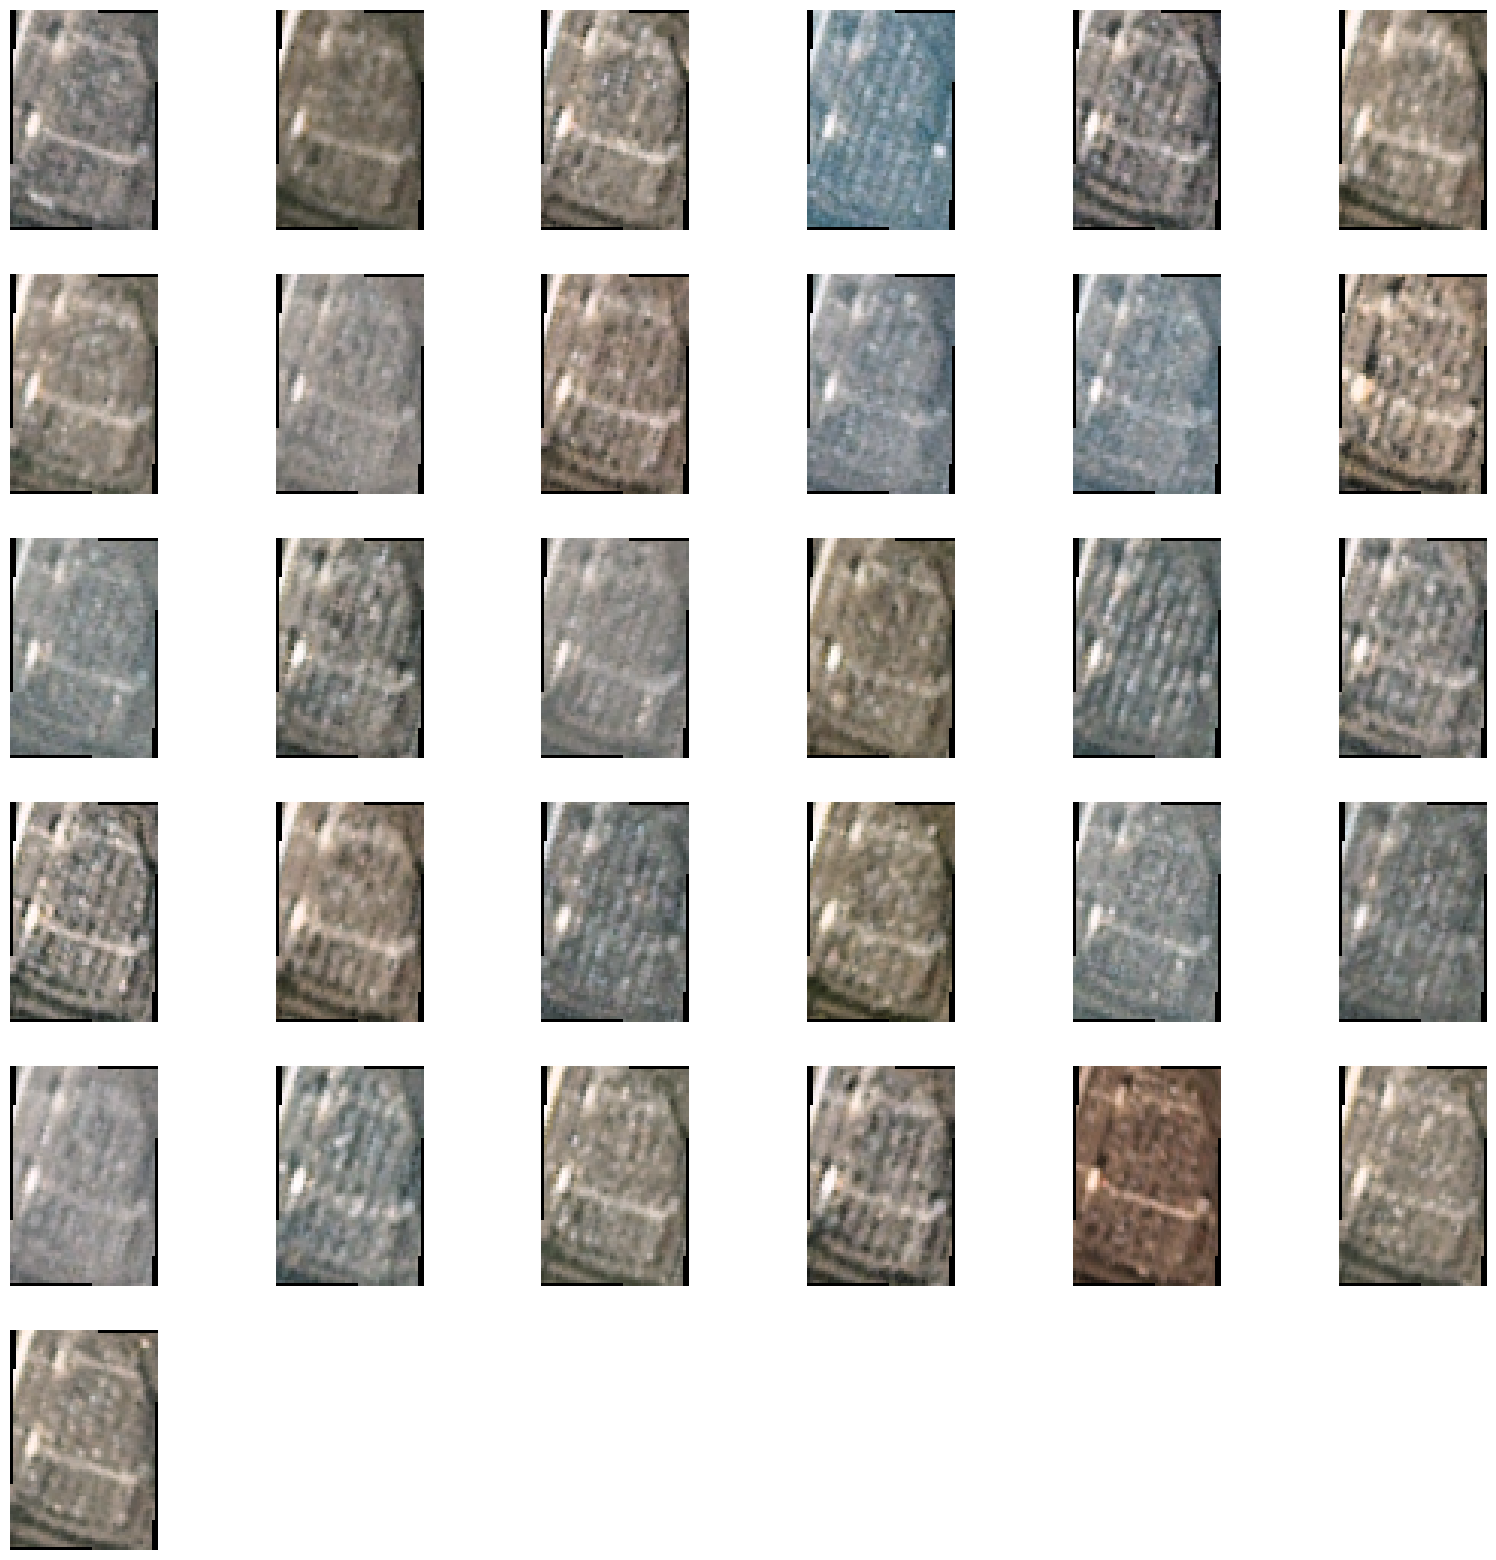

In [47]:
plt.figure(figsize=(20,20))
for i in range(len(df[df.day == 'Saturday'])):
    plt.subplot(6,6,i+1)
    img = rioxarray.open_rasterio(df[df.day == 'Saturday'].image_path.values[i])
    plt.imshow(img.data[0:3].transpose(1, 2, 0))
    plt.axis('off')

In [45]:
len(df[df.day == 'Saturday'])

31